In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import pickle

import time

from abc import ABC, abstractmethod

import os

from skopt import Optimizer
from skopt.space import Real

import scipy.stats as st

from rich.table import Table
from rich.console import Console

from joblib import Parallel, delayed

from scipy.special import softmax
import math
import random

from collections import namedtuple, deque
from itertools import count

import tensorflow as tf
import keras

import sklearn
import sklearn.neural_network

import torch

2024-09-16 16:58:15.911828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 16:58:15.931979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 16:58:15.937637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 16:58:15.953038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 16:58:16.921135: W tensorflow/compiler/tf2

# Traccia A3
L’obiettivo del progetto è implementare e valutare una o più soluzioni basate su reinforcement learning per il problema Mountain Car della suite OpenAI Gymnasium: https://gym.farama.org/environments/classic_control/mountain_car/

## Description
The Mountain Car MDP is a deterministic environment where a car must reach the top of a hill by overcoming gravity. The car is initially placed in a valley, and the agent needs to apply strategic accelerations to reach the goal.

## Observation Space
- **Shape:** `(2,)`
- **Elements:**
  - Position: `[-1.2, 0.6]` (meters)
  - Velocity: `[-0.07, 0.07]` (meters/second)

## Action Space
- **Discrete(3)**
  1. Accelerate left
  2. No acceleration
  3. Accelerate right

## Transition Dynamics
- Updates based on applied force, velocity, and gravity. Inelastic collisions occur at boundaries.

## Reward
- Constant reward of `-1` per timestep until the goal is reached.

## Starting State
- Position: Uniform random in `[-0.6, -0.4]`
- Velocity: `0`

## Episode End
1. **Termination:** Position ≥ 0.5 (goal reached)
2. **Truncation:** 200 timesteps


In [2]:
PROBLEM_NAME = 'MountainCar-v0'

MAX_EPISODE_STEPS = 200
SPACE_RANGE = [-1.2, 0.6]
VEL_RANGE = [-0.07, 0.07]
ACTION_SPACE = 3

# Aspetti Generali

Di seguito vengono definite le tre classi a partire dal quale viene generalizzato il problema:
* La classe *QFunction* definisce un'implementazione della Action Value Function. L'uso di questa classe permette di costruire delle Policy che siano indipendenti dalla particolare implementazione della funzione
* La classe *Policy* definisce un'implementazione di una Politica. Le azioni che la politica restituisce potranno essere sia casuali (esplorazione) sia dettate dai volori attuali della *QFunction* data (sfruttamento della conoscenza acquisita).
* La classe *Agent* definisce un agente che interagisce con l'ambiente seguendo le azioni dettate dalla politica che segue.

I seed passati ai vari metodi sono usati per l'inizializzazione dell'ambiente e dei generatori di numeri casuali al fine di avere la riproducibilità tra run diverse.

In [3]:
class QFunction(ABC) :

    @abstractmethod
    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, targetValue) :
        pass

    @abstractmethod
    def getValue(self, state, action) -> float :
        pass

    @abstractmethod
    def getValues(self, state) -> np.ndarray :
        pass

In [4]:
class Policy(ABC) :
    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction) :
        self.alpha = alpha
        self.gamma = gamma
        self.explorePerc = explorePerc

        self.function = function

    
    @abstractmethod
    def chooseAction(self, state, training) -> int :
        pass

    @abstractmethod
    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        pass

    @abstractmethod
    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        pass


In [5]:
class Agent :

    def __init__(self, policy : Policy) :
        self.policy = policy

    def oneEpisode(self, env : gym.Env, training : bool) -> list:
        currentState = env.reset()[0]
        done = False
        totalReward = 0
        while (not done) :
            action = self.policy.chooseAction(currentState, training)
            nextState, reward, terminated, truncated, _ = env.step(action)

            done = terminated or truncated
            if training :
                self.policy.updatePolicy(currentState, action, reward, nextState, terminated)

            currentState = nextState
            totalReward += reward
            
        return totalReward


    def train(self, episodeNum : int, seed : int) -> np.ndarray :
        env : gym.Env = gym.make(PROBLEM_NAME)

        env.reset(seed = seed)
        env.action_space.seed(seed = seed)

        rewardArray = np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward = self.oneEpisode(env = env, training = True)
            print("EpisodeIdx >>> ", episodeIdx, " - EpisodeReward >>> ", episodeReward)

            rewardArray[episodeIdx] = episodeReward

            self.policy.updateParams(episodeNum, episodeIdx)

        env.close()

        return rewardArray
    

    def test(self, episodeNum : int, seed : int, display : bool) -> np.ndarray :
        env : gym.Env = gym.make(PROBLEM_NAME)
        
        env.reset(seed = seed)
        env.action_space.seed(seed = seed)

        rewardArray = np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward  = self.oneEpisode(env, False)
            rewardArray[episodeIdx] = episodeReward

        env.close()

        return rewardArray
    
    def getPolicy(self) -> Policy :
        return self.policy


In [6]:
TRAIN_SEED = 0
TUNE_SEED = 1
TEST_SEED = 2

TUNER_RANDOM_STATE = 3
TORCH_RANDOM_STATE = 4

## Policy

Di seguito vengono proposte due implementazioni di Policy, una basata su Q-Learning e l'altra basata su Sarsa.

Nelle implementazioni proposte è stato adottato un approccio $\epsilon$-greedy con decadimento lineare fino a raggiungimento dello zero: il tasso di decadimento è determinato da un parametro che è la percentuale di episodi in cui si vuole che la $\epsilon$ sia non nulla. Allo stesso modo è stato implementato un approccio Softmax Action Selection con tau a decadimento lineare seguendo la stessa logica.

In entrambi i casi vengono inizializzati dei generatori di numeri randomici per l'esplorazione e la scelta della prossima azione casuale.

Come riportato in https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/, quando si raggiunge lo stato terminale, il valore $Q(s_{t+1}, *)$ non può essere definito, in quanto l'interazione agente-ambiente è terminata e non esiste in realtà uno stato successivo. Il valore del parametro *terminated* viene quindi usato proprio per discriminare queste situazioni e porre il valore del target come uguale al reward.

Il valore del target così calcolato viene passato come parametro alla function insieme anche alle informazioni $(s_t, a_t, r_t, s_{t+1})$ in modo da avere maggior flessibilità nell'aggiornamento della funzione (banalmente la soluzione con approssimazione basata su DQN non vuole il valore del taget, ma tutte le altre informazioni).

### Q-Learning
In questo algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma \cdot max_{a} Q(S',a) - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [7]:
class EpsilonQ(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)


    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        
        if (self.exploreRng.random() < self.epsilon) :
            return self.actionChooseRng.choice(ACTION_SPACE)
        else :
            return np.argmax(self.function.getValues(state))


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            target += self.gamma * np.max(self.function.getValues(nextState))
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0)
        else :
            self.epsilon = 0
        

In [8]:
class TauQ(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)


    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        
        distribution = softmax(self.function.getValues(state) / self.epsilon)
        return self.actionChooseRng.choice(ACTION_SPACE, p = distribution)


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            target += self.gamma * np.max(self.function.getValues(nextState))
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.0001)
        else :
            self.epsilon = 0.0001
        

### Sarsa-Learning
In questo algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata

In [9]:
class EpsilonSarsa(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)

    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        
        if (self.exploreRng.random() < self.epsilon) :
            return self.actionChooseRng.choice(ACTION_SPACE)
        else :
            return np.argmax(self.function.getValues(state))


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            nextAction = self.chooseAction(nextState, True)
            target += self.gamma * self.function.getValue(nextState, nextAction)
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0)
        else :
            self.epsilon = 0

In [10]:
class TauSarsa(Policy) :

    def __init__(self, alpha : float, gamma : float, explorePerc : float, function : QFunction, seed : int, epsilon : float) :
        super().__init__(alpha, gamma, explorePerc, function)
        self.seed = seed
        self.baseEpsilon = epsilon
        self.epsilon = epsilon

        self.exploreRng = np.random.default_rng(seed)
        self.actionChooseRng = np.random.default_rng(seed)

    def chooseAction(self, state, training) -> int :
        if (not training) :
            return np.argmax(self.function.getValues(state))
        
        distribution = softmax(self.function.getValues(state) / self.epsilon)
        return self.actionChooseRng.choice(ACTION_SPACE, p = distribution)


    def updatePolicy(self, state : np.ndarray, action : int, reward : float, nextState : np.ndarray, terminated : bool) -> None :
        target = reward
        if (not terminated) :
            nextAction = self.chooseAction(nextState, True)
            target += self.gamma * self.function.getValue(nextState, nextAction)
        self.function.updateFunction(state, action, reward, nextState, terminated, self.alpha, self.gamma, target)


    def updateParams(self, totalEpisodeNum, currentEpisodeIdx) :
        exploreEpisodeNum = int(totalEpisodeNum * self.explorePerc)
        if (currentEpisodeIdx < exploreEpisodeNum) :
            self.epsilon = self.baseEpsilon - (currentEpisodeIdx / exploreEpisodeNum) * (self.baseEpsilon - 0.0001)
        else :
            self.epsilon = 0.0001

# Utils

In [11]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table:
    table = Table(title = testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

# Soluzione con ricerca tabulare
Per definire delle soluzioni basate su ricerca tabulare, abbiamo bisogno prima di tutto di una matrice che ci tenga traccia dei valori della funzione $Q(s,a)$. In questo caso specifico lo stato del problema non è discreto, bensì continuo, in quanto formato da i valori della posizione e della velocità i quali a loro volta variano in un insieme continuo.

Al fine di definire delle soluzioni basate su ricerca tabulare quindi definiamo una discretizzazione dello stato che ci permetta di definire la funzione $Q(s,a)$; notiamo invece che per quanto riguarda l'insieme $A$ delle azioni esso è già discreto e non ci dà problemi in termini di definizione della funzione.

Una soluzione basata su questo tipo di soluzioni comporta un consumo di memoria dato da $|S| \cdot |A|$, dove $|A|$ nel nosto caso è pari a $3$, mentre $|S|$ dipende dalla discretizzazione che facciamo dello stato: supposto di dividere l'inervallo della posizione in $5$ slot e quello delle velocità in altrettanti, avremo un numero totale di stati pari a $25$.

In questo caso, come si vede dall'implementazione, il valore dell'incremento della funzione viene calcolato partendo dal target e applicando la relazione:   

$Q(S,A) \leftarrow Q(S,A) + \alpha [target - Q(S,A)]$

In [12]:
class BucketQFunction(QFunction) :

    def __init__(self, spaceRange : list, spaceBins : int, velRange : list, velBins : int, actionSpace : int) :
        self.q : np.ndarray = np.zeros([spaceBins, velBins, actionSpace])

        self.spaceLinSpace = np.linspace(
            spaceRange[0], 
            spaceRange[1], 
            spaceBins + 1
        )

        self.velLinSpace = np.linspace(
            velRange[0], 
            velRange[1], 
            velBins + 1
        )

    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, targetValue):
        spaceSlot, velSlot = self._computeSlots(currentState)
        increment = alpha * (targetValue - self.getValue(currentState, action))

        self.q[spaceSlot, velSlot, action] += increment
    
    def getValue(self, state, action):
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, action]
    
    def getValues(self, state) :
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, :]
    
    def _computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return spaceSlot, velocitySlot

## Tuning

Di seguito si procede alla sintonizzazione degli iperparametri.
Come iperparametri da sintonizzare sono stati considerati i seguenti:
* $\alpha$, learning rate
* $\gamma$, fattore di sconto
* $\epsilon$, parametro di esplorazione

Altri iperparametri che non sono stati calibrati, ma sono stati scelti ad occhio per non rallentare eccessivamente l'esecuzione sono stati:
* Numero di Episodi di Addestramento: impostato a $5000$
* Percentuale di Episodi di Esplorazione : impostato a $50\%$. Questo significa che per $2500$ episodi la probabilità di esplorazione è non nulla.
* Numero di beans: impostato a $20$. Il valore permette una buona discretizzazione sia dello spazio sia della velocità. Nello specifico:
    * Lo spazio è diviso in intervalli di lunghezza $0.09$
    * La velocità è divisa in intervalli di lunghezza $0.007$

La sintonizzazione è stata effettuata con l'uso della libreria *scikit-optimize* che permette una valutazione in parallelo dei punti. Vengono valutati 5 punti per volta con 5 processi paralleli e si vede quale fornisce il valore migliore: il numero totale di combinazioni considerate è 75, per un totale di 15 richieste di punti.

Sono state considerate due varianti per la funzione obbiettivo:
* Una che considera soltanto il reward medio ottenuto
* Una che considera il reward medio ottenuto e anche la deviazione standard. Questo permette di penalizzare soluzioni caratterizzate da una maggiore varianza e instabilità della soluzione, quindi l'aggiunta di questo termine può essere considerata come l'aggiunta di una funzione di regolarizzazione.

Gli ambienti sono stati addestrati considerando sempre lo stesso seed per l'ambiente e per il generatore di numeri casuali, mentre la valutazione del modello viene fatta su un ambiente costruito su un seed diverso e valutando su 100 esecuzioni.

In [13]:
TRAIN_EPISODES = 5_000

In [14]:
class Tuner() :

    def __init__(self, PolicyClass, trainEpisodes : int, tuneEpisodes : int, trainSeed : int, tuneSeed : int, withStd : bool) :
        self.PolicyClass = PolicyClass
        self.trainEpisodes = trainEpisodes
        self.tuneEpisodes = tuneEpisodes
        self.trainSeed = trainSeed
        self.tuneSeed = tuneSeed
        self.withStd = withStd

    def objective(self, params):
        alpha, gamma, epsilon = params

        function = BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        policy = self.PolicyClass(alpha, gamma, 0.5, function, self.trainSeed, epsilon)
        agent = Agent(policy)
        trainRewardArray = agent.train(self.trainEpisodes, self.trainSeed)
        tuneRewardArray= agent.test(self.tuneEpisodes, self.tuneSeed, False)
        
        meanTune = -tuneRewardArray.mean()
        stdDev = np.sqrt(tuneRewardArray.var())
        if (self.withStd) :
            objValue = meanTune + stdDev
        else :
            objValue = meanTune
        return objValue
    
    def tune(self, calls, randomState, space, jobsNum) :

        optimizer = Optimizer(
            dimensions = space, 
            random_state = randomState,
        )

        for i in range(calls // jobsNum):
            print(f"Step >>> {i}")
            x = optimizer.ask(n_points=jobsNum)  # x is a list of n_points points
            # for params in x :
            #     print(f"Attempt >>> {params}")
                
            y = Parallel(
                n_jobs = jobsNum
            )(delayed(self.objective)(params) for params in x)  # evaluate points in parallel
            optimizer.tell(x, y)

            bestIdx = np.argmin(optimizer.yi)
            print(f"Best Value So Far >>> {optimizer.yi[bestIdx]}")
            print(f"Best Params So Far >>> {optimizer.Xi[bestIdx]}")
            print()
        
        bestIdx = np.argmin(optimizer.yi)
        print(f"Best Value >>> {optimizer.yi[bestIdx]}")
        print(f"Best Params >>> {optimizer.Xi[bestIdx]}")
        print()
        print()

        return optimizer.Xi[bestIdx]

In [15]:
def tuneLearner(Policy, trainEpisodes, bestDict, fileName : str, withStd : bool) -> list :
    key = (Policy.__name__, withStd)
    if (not key in bestDict) :
        space = [
            Real(0.01, 0.4, name = 'alpha'),
            Real(0.8, 1.0, name = 'gamma'),
            Real(0.5, 1.0, name = "epsilon"),
        ]
        bestParams = Tuner(Policy, trainEpisodes, 100, TRAIN_SEED, TUNE_SEED, withStd).tune(75, TUNER_RANDOM_STATE, space, 5)
        bestDict[key] = bestParams
        with open(fileName, 'wb') as f:
            pickle.dump(bestDict, f)
    else :
        bestParams = bestDict[key]

    return bestParams

## Epsilon-Learning

### Tuning

In [16]:
EPSILON_PARAMS_FILE_NAME = './EpsilonParams.pkl'

if (os.path.exists(EPSILON_PARAMS_FILE_NAME)) :
    with open(EPSILON_PARAMS_FILE_NAME, 'rb') as f:
        epsilonParamsDict = pickle.load(f)
else :
    epsilonParamsDict = {}

tuneLearner(EpsilonQ, TRAIN_EPISODES, epsilonParamsDict, EPSILON_PARAMS_FILE_NAME, False)
tuneLearner(EpsilonSarsa, TRAIN_EPISODES, epsilonParamsDict, EPSILON_PARAMS_FILE_NAME, False)

tuneLearner(EpsilonQ, TRAIN_EPISODES, epsilonParamsDict, EPSILON_PARAMS_FILE_NAME, True)
tuneLearner(EpsilonSarsa, TRAIN_EPISODES, epsilonParamsDict, EPSILON_PARAMS_FILE_NAME, True)


[0.09781487855634256, 0.9634092535612564, 0.6198209286918297]

In [17]:
table = buildTable("Best Params", ["LearnerName", "With Std", "Alpha", "Gamma", "Epsilon"], [False, False, True, True, True])
for key in epsilonParamsDict :
    table.add_row(key[0], str(key[1]), str(epsilonParamsDict[key][0]), str(epsilonParamsDict[key][1]), str(epsilonParamsDict[key][2]))

Console().print(table)

                                        Best Params                                        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ With Std ┃ Alpha               ┃ Gamma              ┃ Epsilon            ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ EpsilonQ     │ True     │ 0.27334359763091337 │ 1.0                │ 0.6500012996863475 │
│ EpsilonSarsa │ True     │ 0.09781487855634256 │ 0.9634092535612564 │ 0.6198209286918297 │
│ EpsilonQ     │ False    │ 0.21446396736911216 │ 0.8                │ 0.5                │
│ EpsilonSarsa │ False    │ 0.2333891131644621  │ 1.0                │ 1.0                │
└──────────────┴──────────┴─────────────────────┴────────────────────┴────────────────────┘

Dagli iperparametri trovati possiamo vedere come il valore del parametro $\alpha$ sia abbastanza diverso tra il QLearning e il Sarsa: questo potrebbe essere dovuto al modo in cui il Sarsa sceglie il valore $Q(s_{t+1}, a_{t+1})$: in questo caso l'azione $a_{t+1}$ è scelta seguendo la stessa politica con cui viene scelta l'azione $a_t$; essendo la scelta dell'azione in parte dovuta alla casualità, è possibile che un valore di $\alpha$ troppo grande rendesse l'algoritmo più instabile.

I valori del $\gamma$ invece sono molto alti e tendono al valore $1$, come è normale che accada in un task episodico, in cui l'interazione tra agente ed ambiente termina.

### Addestramento
Trovati i parametri migliori procediamo all'addestramento degli agenti con questi parametri e a tracciare le curve di addestramento

In [18]:
def plotTrainTrend(rewardArray : np.ndarray, episodeNum : int, learnerName : str) :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

    axes[0].plot(np.array(rewardArray))
    axes[0].set_xlabel("Episode Idx")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Reward During Training")
    axes[0].grid(True)
    
    mean_rewards = np.zeros(episodeNum)
    for t in range(episodeNum):
            mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
    axes[1].plot(mean_rewards)
    axes[1].set_xlabel("Episode Idx")
    axes[1].set_ylabel("Avg Reward - 100 Episodes")
    axes[1].set_title("Avg Reward Trend During Training")
    axes[1].grid(True)

    fig.suptitle(f"{learnerName} - Training")
    plt.tight_layout()
    plt.show()
    plt.clf()

In [19]:
EPSILON_TRAINED_FILE_NAME = "./EpsilonTrained.pkl"
def trainAgent(PolicyClass, fileName, trainDict, bestParamsDict, episodeNum, withStd) -> tuple[Policy, np.ndarray] :
    key = (PolicyClass.__name__, withStd)
    if (not key in trainDict) :
        alpha, gamma, epsilon = bestParamsDict[key]
        function = BucketQFunction(SPACE_RANGE, 20, VEL_RANGE, 20, ACTION_SPACE)
        policy = PolicyClass(alpha, gamma, 0.5, function, TRAIN_SEED, epsilon)
        agent = Agent(policy)

        rewardArray = agent.train(episodeNum, TRAIN_SEED)
        
        trainDict[key] = [policy, rewardArray]
        with open(fileName, 'wb') as f:
            pickle.dump(trainDict, f)
    else :
        policy : Policy = trainDict[key][0]
        rewardArray = trainDict[key][1]
    
    plotTrainTrend(rewardArray, episodeNum, key)

    return policy, rewardArray

In [20]:
if (os.path.exists(EPSILON_TRAINED_FILE_NAME)) :
    with open(EPSILON_TRAINED_FILE_NAME, 'rb') as f:
        epsilonTrainedDict = pickle.load(f)
else :
    epsilonTrainedDict = {}


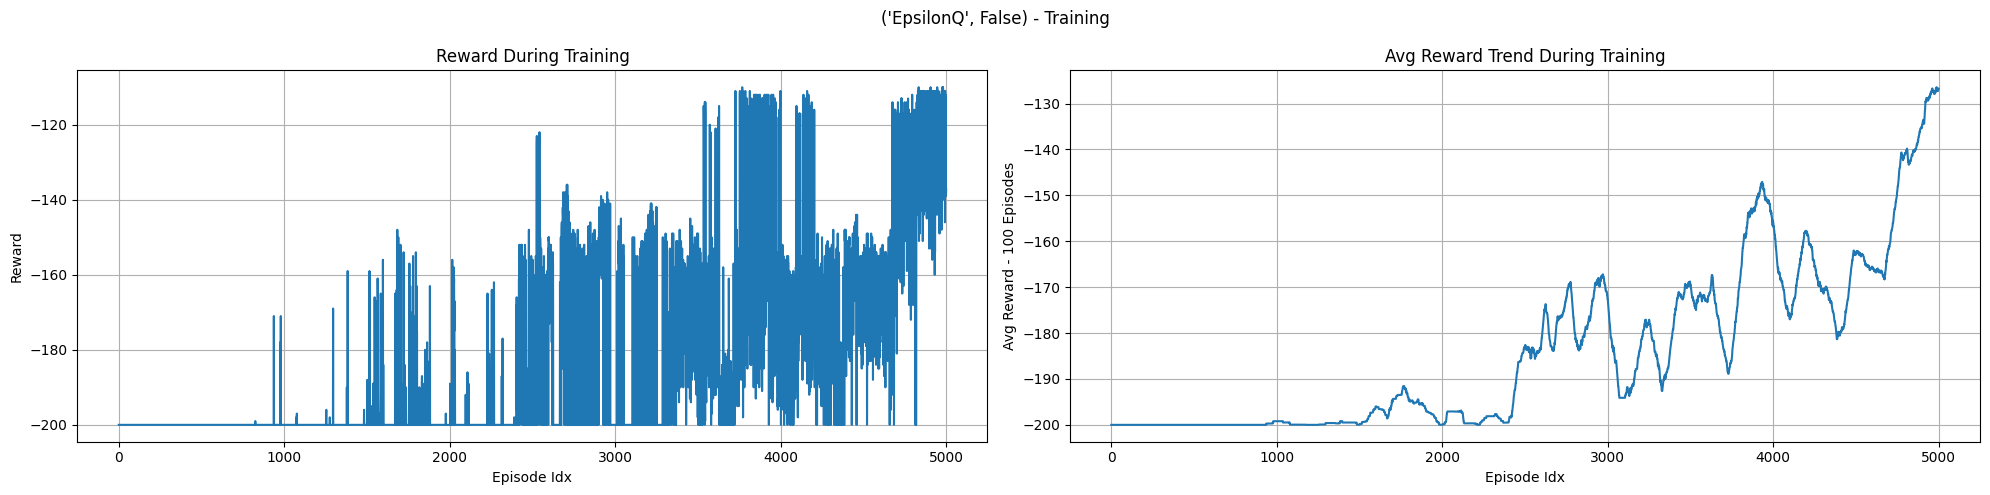

<Figure size 640x480 with 0 Axes>

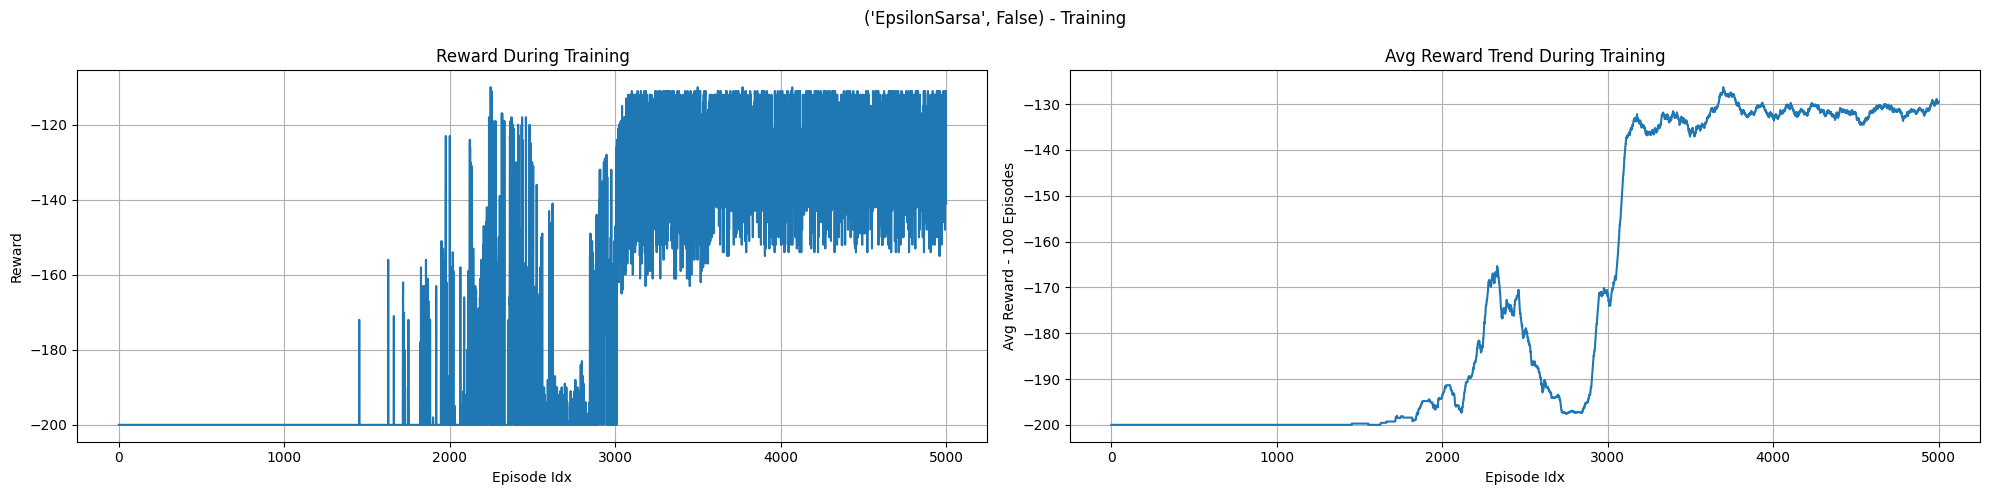

<Figure size 640x480 with 0 Axes>

In [21]:
epsilonQ, _ = trainAgent(EpsilonQ, EPSILON_TRAINED_FILE_NAME, epsilonTrainedDict, epsilonParamsDict, TRAIN_EPISODES, False)
epsilonSarsa, _ = trainAgent(EpsilonSarsa, EPSILON_TRAINED_FILE_NAME, epsilonTrainedDict, epsilonParamsDict, TRAIN_EPISODES, False)

Nel caso senza regolarizzazione notiamo come la soluzione con il Sarsa sia quella che si stabilizza, mentre quella del QLearning fatichi di più, sebbene al termine dell'addestramento entrambe le suluzioni arrivino a valori simili di reward.

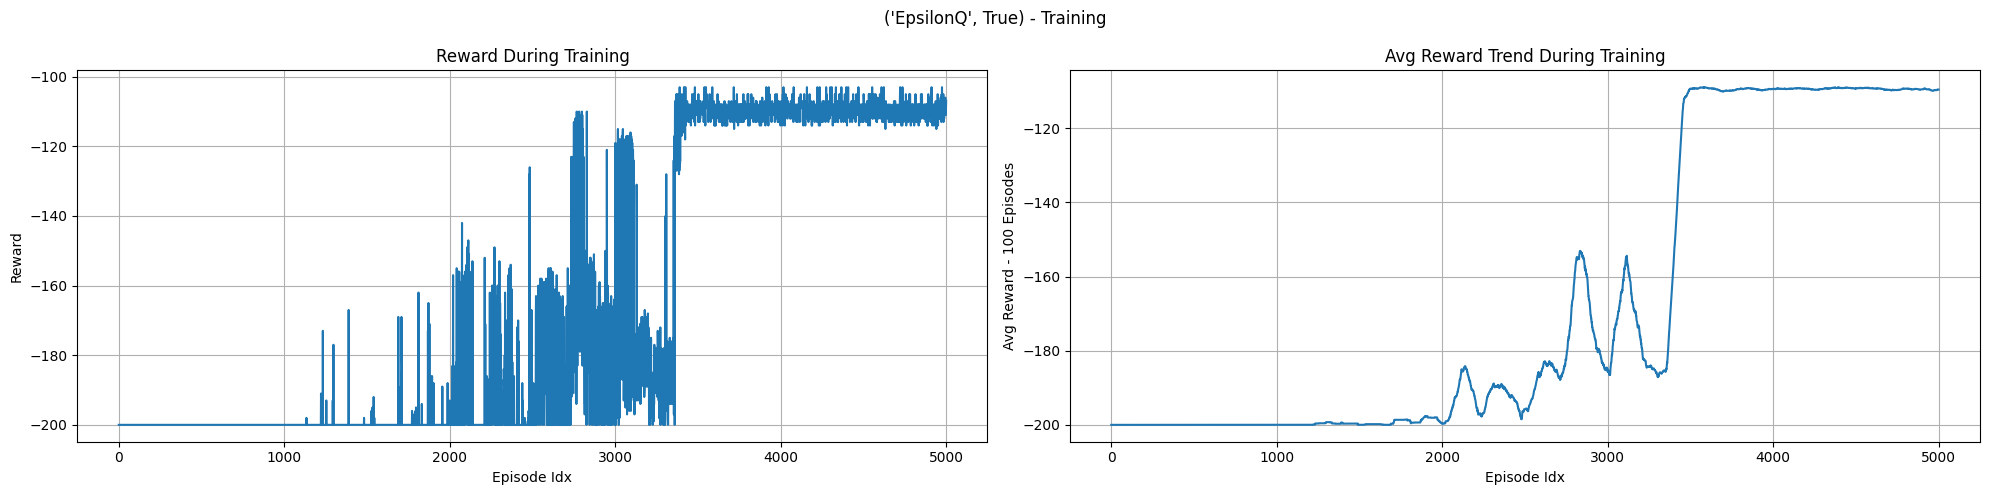

<Figure size 640x480 with 0 Axes>

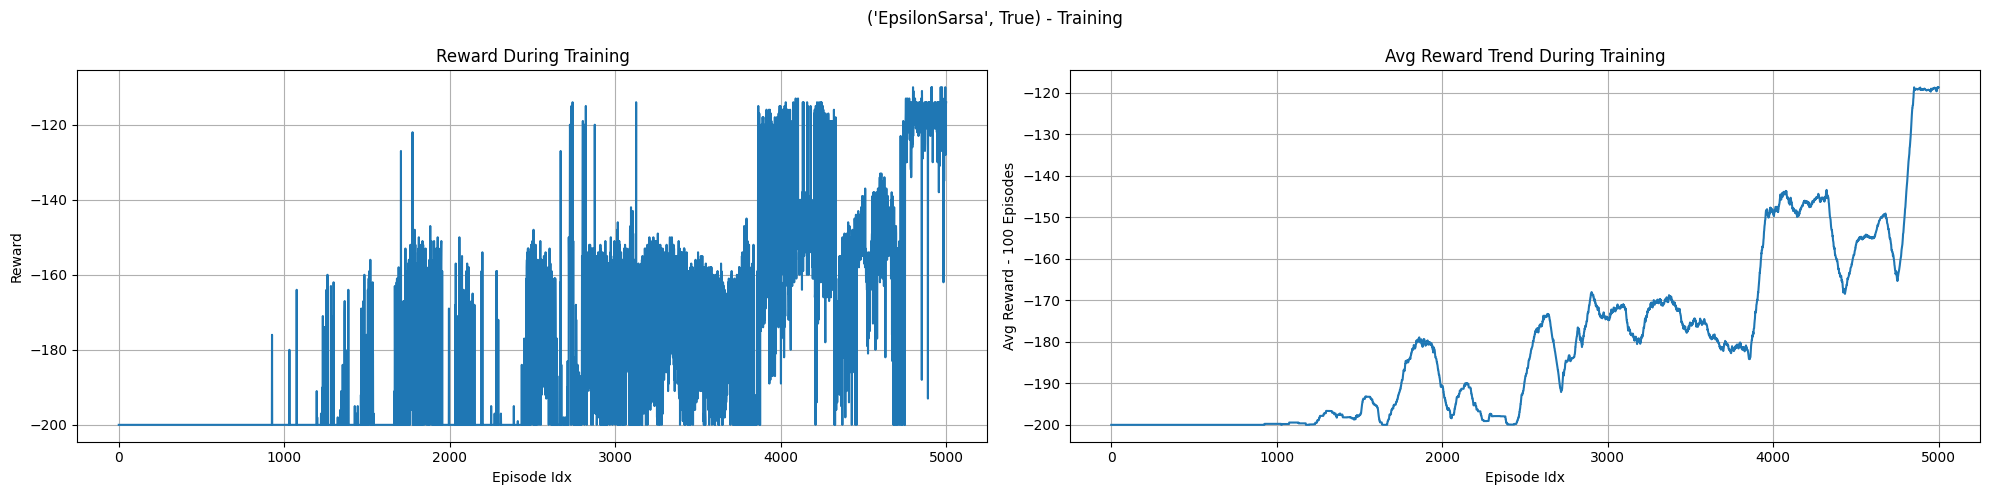

<Figure size 640x480 with 0 Axes>

In [22]:
epsilonQ_std, _ = trainAgent(EpsilonQ, EPSILON_TRAINED_FILE_NAME, epsilonTrainedDict, epsilonParamsDict, TRAIN_EPISODES, True)
epsilonSarsa_std, _ = trainAgent(EpsilonSarsa, EPSILON_TRAINED_FILE_NAME, epsilonTrainedDict, epsilonParamsDict, TRAIN_EPISODES, True)

Nel caso con regolarizzazione invece è il contrario: la soluzione con QLearning è quella che si stabilizza più facilmente, mentre quella con Sarsa fa più difficoltà, sebbene nella parte finale vi sia un accenno di stabilizzazione del reward.

Per concludere è possibile che un maggior numero di episodi per l'addestramento possa portare a convergere anche gli algoritmi che con $5000$ episodi non riescono.

### Testing

In [23]:
TESTING_EPISODES = 100

baseList = []
withStdList = []

for key in epsilonTrainedDict :
    if (key[1]) :
        withStdList.append(epsilonTrainedDict[key][0])
    else :
        baseList.append(epsilonTrainedDict[key][0])

policyList = [baseList, withStdList]

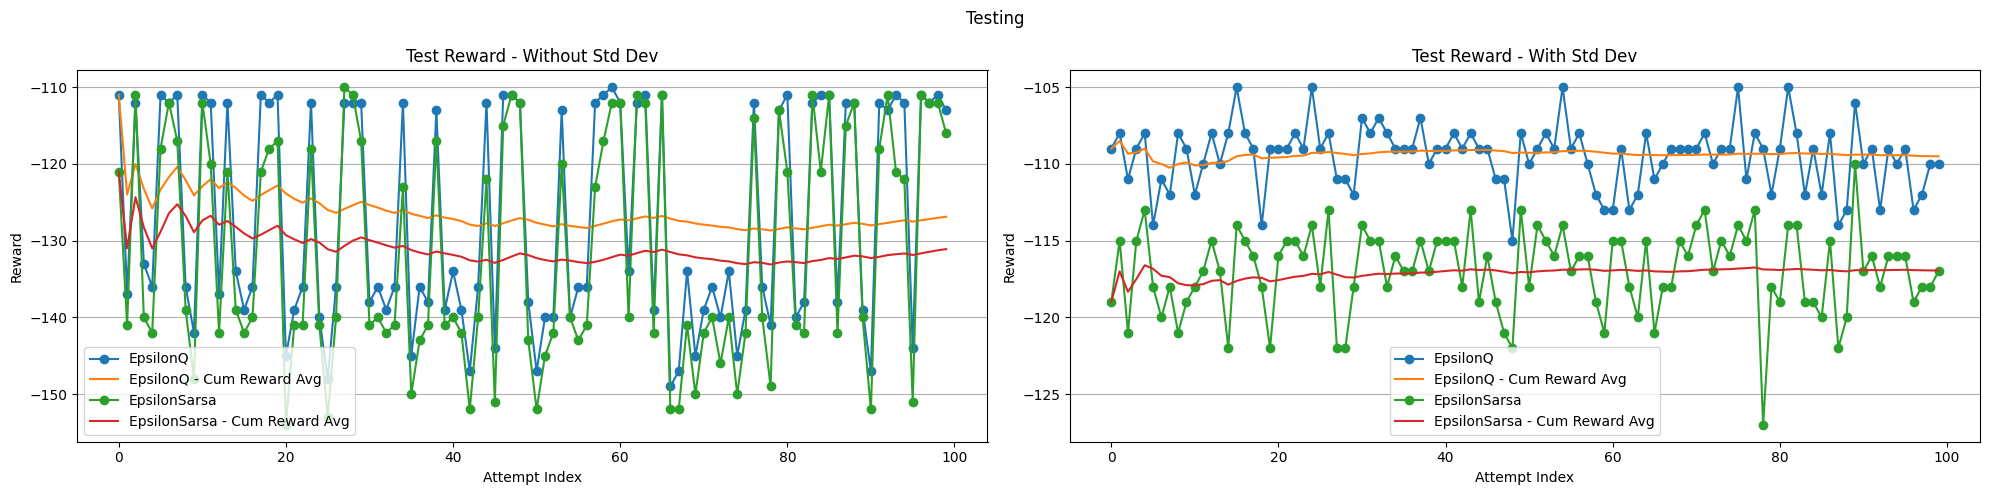

<Figure size 640x480 with 0 Axes>

In [24]:

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

for i in range(0, len(policyList)) :
    currList = policyList[i]

    for policy in currList :
        agent = Agent(policy)
        rewardArray = agent.test(TESTING_EPISODES, TEST_SEED, False)
        axes[i].plot(rewardArray, label = policy.__class__.__name__, marker = "o")

        cumAvg = np.cumsum(rewardArray) / np.arange(1, len(rewardArray) + 1)
        axes[i].plot(cumAvg, label = policy.__class__.__name__ + " - Cum Reward Avg")

    axes[i].legend()
    axes[i].grid(True, axis = "y")
    axes[i].set_ylabel("Reward")
    axes[i].set_xlabel("Attempt Index")

    if i == 0 :
        axes[i].set_title("Test Reward - Without Std Dev")
    else :
        axes[i].set_title("Test Reward - With Std Dev")

fig.suptitle(f"Testing")
plt.tight_layout()
plt.show()
plt.clf()

In [25]:
table = buildTable("Testing Reward Info", ["LearnerName", "With Std", "Avg Reward", "Reward Std Dev", "Confidence Interval 95%"], [False, False, True, True, True])
for policy in baseList :
    agent = Agent(policy)
    rewardArray = agent.test(TESTING_EPISODES, TEST_SEED, False)
    confidenceInterval = st.t.interval(
        confidence = 0.95,
        df = len(rewardArray) - 1,
        loc=np.mean(rewardArray), 
        scale=st.sem(rewardArray)
    )
    confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
    table.add_row(policy.__class__.__name__, str(False), str(rewardArray.mean()), str(rewardArray.std()), confidenceString)

for policy in withStdList :
    agent = Agent(policy)
    rewardArray = agent.test(TESTING_EPISODES, TEST_SEED, False)
    confidenceInterval = st.t.interval(
        confidence = 0.95,
        df = len(rewardArray) - 1,
        loc=np.mean(rewardArray), 
        scale=st.sem(rewardArray)
    )
    confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
    table.add_row(policy.__class__.__name__, str(True), str(rewardArray.mean()), str(rewardArray.std()), confidenceString)


Console().print(table)

                                           Testing Reward Info                                           
┏━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName  ┃ With Std ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ EpsilonQ     │ False    │ -126.88    │ 14.084942314400866 │ -129.68883760527936 / -124.07116239472063 │
│ EpsilonSarsa │ False    │ -131.1     │ 14.67140075112121  │ -134.02578991322807 / -128.17421008677192 │
│ EpsilonQ     │ True     │ -109.5     │ 2.0663978319771825 │ -109.9120837564234 / -109.0879162435766   │
│ EpsilonSarsa │ True     │ -116.94    │ 2.715952871461506  │ -117.4816188713622 / -116.3983811286378   │
└──────────────┴──────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

Analizzando sia le curve di testing sia i dati riportati nella tabella sopra, si vede come sia nel caso con che senza regolarizzazione la soluzione migliore sembri essere quella del QLearning.

Allo stesso tempo possiamo vedere come l'aggiunta della regolarizzazione abbia un effetto positivo sul reward medio di entrambi gli algoritmi; come è ovvio l'aggiunta della regolarizzazione riduce anche la deviazione standard dei risultati.

La soluzione migliore sembra quindi essere quella del QLearning con standardizzazione.

Si fa qui notare che la differenza tra le diverse soluzioni potrebbe dipendere dall'algoritmo di ottimizzazione usato dalla libreria di ricerca che fatica a trovare un punto di ottimo negli altri casi.

## Softmax Action-Selection
Vediamo se una scelta diversa delle azioni impatta i risultati dell'algoritmo e consideriamo una Softmax-Action-Selection. Analizziamo in questo caso solo la soluzione con regolarizzazione visto che quella senza nei casi precedenti non ha dato buoni risultati.

Di seguito il parametro $\epsilon$ viene usato nel ruolo del $\tau$.

### Tuning

In [26]:
TAU_PARAMS_FILE_NAME = "TauParams.pkl"
if (os.path.exists(TAU_PARAMS_FILE_NAME)) :
    with open(TAU_PARAMS_FILE_NAME, 'rb') as f:
        tauParamsDict = pickle.load(f)
else :
    tauParamsDict = {}

tuneLearner(TauQ, TRAIN_EPISODES, tauParamsDict, TAU_PARAMS_FILE_NAME, True)
tuneLearner(TauSarsa, TRAIN_EPISODES, tauParamsDict, TAU_PARAMS_FILE_NAME, True)

[0.20543193985550307, 1.0, 0.5]

In [27]:
table = buildTable("Best Params", ["LearnerName", "With Std", "Alpha", "Gamma", "Epsilon"], [False, False, True, True, True])
for key in tauParamsDict :
    table.add_row(key[0], str(key[1]), str(tauParamsDict[key][0]), str(tauParamsDict[key][1]), str(tauParamsDict[key][2]))

Console().print(table)

                           Best Params                            
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓
┃ LearnerName ┃ With Std ┃ Alpha               ┃ Gamma ┃ Epsilon ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩
│ TauQ        │ True     │ 0.3045803691144027  │ 1.0   │ 1.0     │
│ TauSarsa    │ True     │ 0.20543193985550307 │ 1.0   │ 0.5     │
└─────────────┴──────────┴─────────────────────┴───────┴─────────┘

### Addestramento

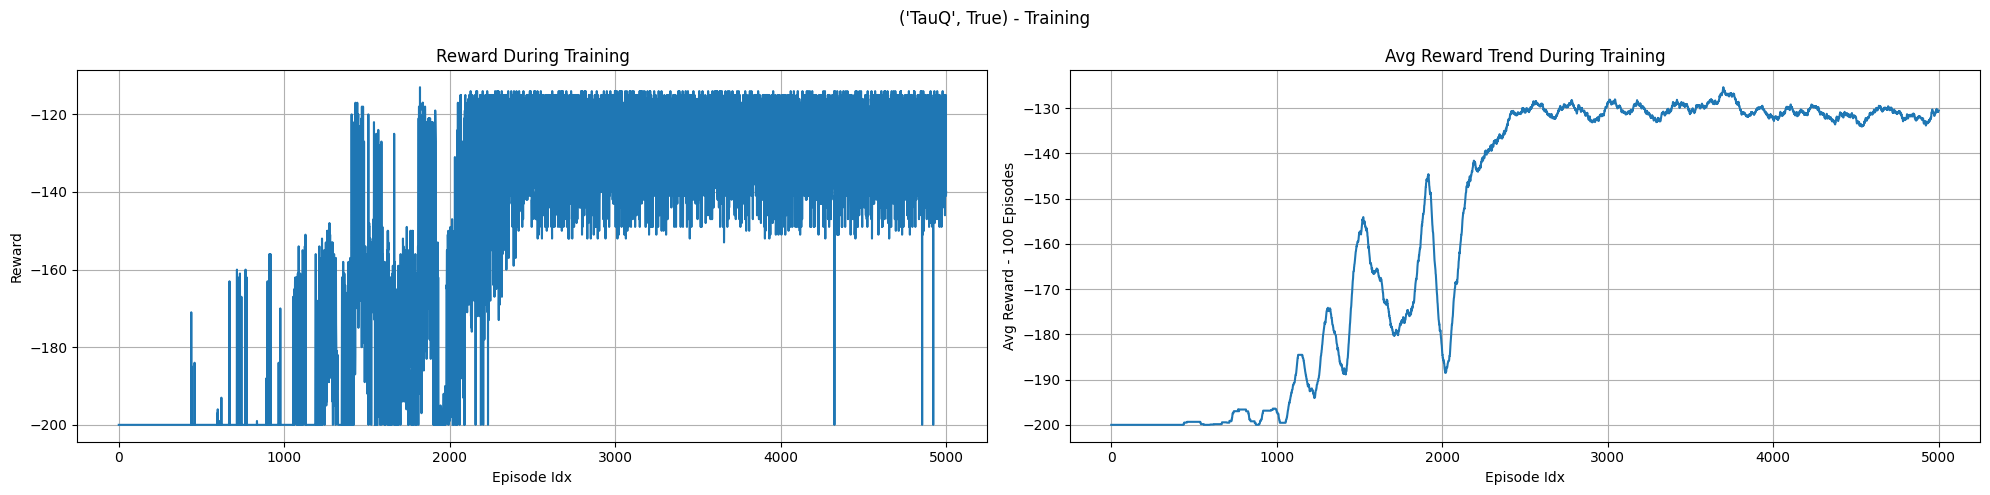

<Figure size 640x480 with 0 Axes>

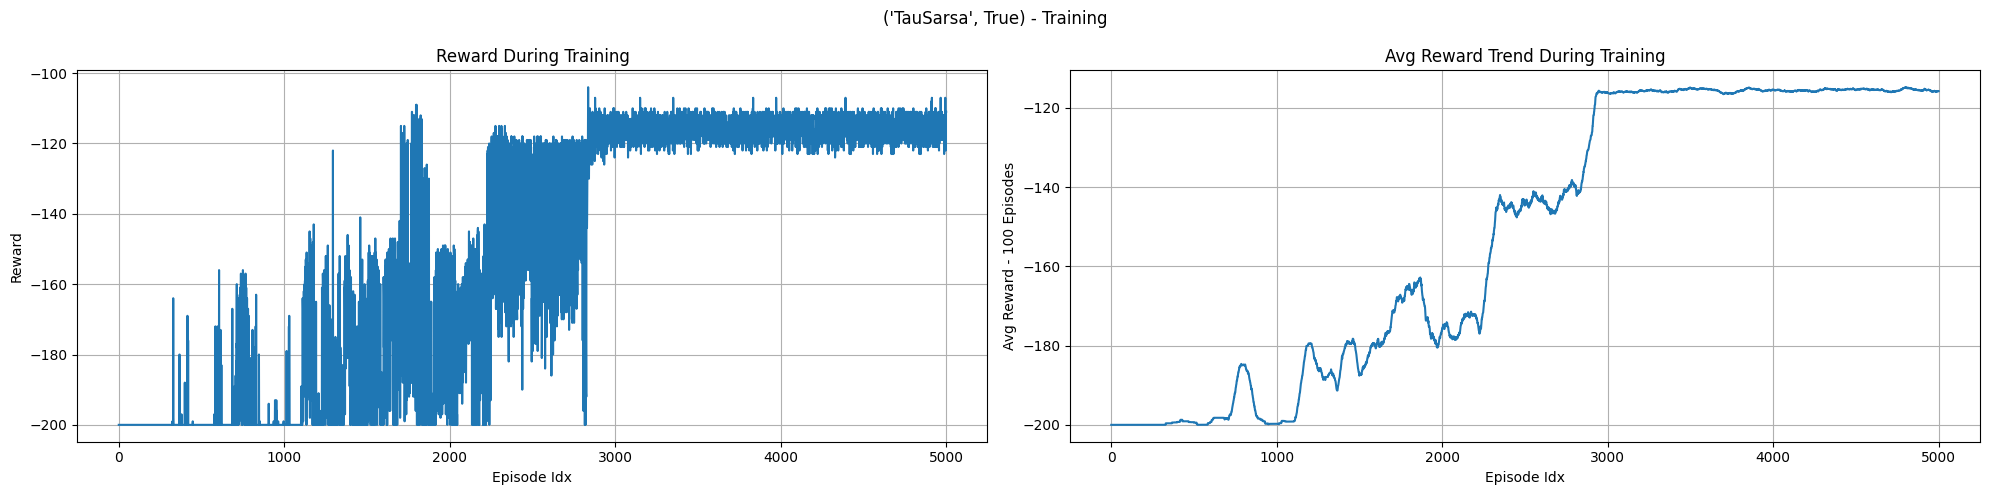

<Figure size 640x480 with 0 Axes>

In [28]:
TAU_TRAINED_FILE_NAME = "TauTrained.pkl"

if (os.path.exists(TAU_TRAINED_FILE_NAME)) :
    with open(TAU_TRAINED_FILE_NAME, 'rb') as f:
        tauTrainedDict = pickle.load(f)
else :
    tauTrainedDict = {}

tauQ, _ = trainAgent(TauQ, TAU_TRAINED_FILE_NAME, tauTrainedDict, tauParamsDict, TRAIN_EPISODES, True)
tauSarsa, _ = trainAgent(TauSarsa, TAU_TRAINED_FILE_NAME, tauTrainedDict, tauParamsDict, TRAIN_EPISODES, True)

L'uso della Softmax Action Selection permette di convergere in entrambi i casi.

### Testing

In [29]:
tauList = [tauQ, tauSarsa]

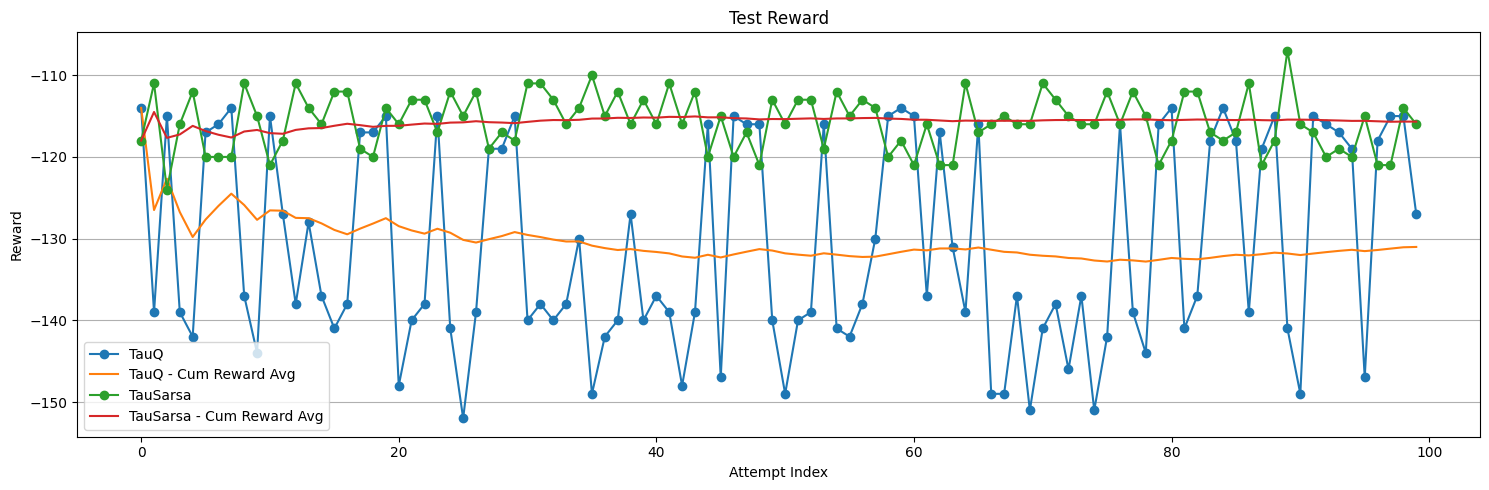

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize = (15,5))

for policy in tauList :
    agent = Agent(policy)
    rewardArray = agent.test(TESTING_EPISODES, TEST_SEED, False)
    plt.plot(rewardArray, label = policy.__class__.__name__, marker = "o")

    cumAvg = np.cumsum(rewardArray) / np.arange(1, len(rewardArray) + 1)
    plt.plot(cumAvg, label = policy.__class__.__name__ + " - Cum Reward Avg")

plt.legend()
plt.grid(True, axis = "y")
plt.ylabel("Reward")
plt.xlabel("Attempt Index")
plt.title("Test Reward")
plt.tight_layout()
plt.show()
plt.clf()

In [31]:
table = buildTable("Testing Reward Info", ["LearnerName", "With Std", "Avg Reward", "Reward Std Dev", "Confidence Interval 95%"], [False, False, True, True, True])

for policy in tauList :
    agent = Agent(policy)
    rewardArray = agent.test(TESTING_EPISODES, TEST_SEED, False)
    confidenceInterval = st.t.interval(
        confidence = 0.95,
        df = len(rewardArray) - 1,
        loc=np.mean(rewardArray), 
        scale=st.sem(rewardArray)
    )
    confidenceString = str(confidenceInterval[0]) + " / " + str(confidenceInterval[1])
    table.add_row(policy.__class__.__name__, str(True), str(rewardArray.mean()), str(rewardArray.std()), confidenceString)


Console().print(table)

                                          Testing Reward Info                                           
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ LearnerName ┃ With Std ┃ Avg Reward ┃ Reward Std Dev     ┃ Confidence Interval 95%                   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ TauQ        │ True     │ -131.02    │ 12.649094829275334 │ -133.54249902315092 / -128.4975009768491  │
│ TauSarsa    │ True     │ -115.68    │ 3.3730698184294967 │ -116.35266199177478 / -115.00733800822523 │
└─────────────┴──────────┴────────────┴────────────────────┴───────────────────────────────────────────┘

Come si vede dai grafici e dalla tabella, a raggiungere i risultati migliori questa volta è il Sarsa, con un reward medio simile a quello ottenuto nel caso dello stesso algoritmo con strategia $\epsilon$-greedy.

L'algoritmo del QLearning in questo caso non sembra performare bene visto che presenta sia un reward medio basso ma anche una varianza elevata.

# Soluzione con approssimazione

## Approssimazione con DQN

La soluzione con approssimazione è state realizzata usando la libreria Pytorch seguendo il tutorial riportato al link https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html. Il motivo dietro l'uso di pytorch sta nei tempi di esecuzione: inizialmente era stato provato un approccio basato su Keras e Tensorflow, ma questo richiedeva un tempo di eseguzione molto lungo di anche diversi minuti per un singolo episodio sebbene l'uso di GPU. PyTorch invece, sebbene richieda anche lui un tempo non brevissio (circa un secondo o un secondo e mezzo per episodio), è risultato essere molto più efficiente in termini di tempo di esecuzione anche senza l'uso di una GPU.

In generale è stato notato che l'uso della GPU non porta particolari miglioramenti in termini prestazionali: questo è probabilmente dovuto al fatto che essendo i batch su cui si fanno i passi piccoli ed essendo fatto un singolo passo per volta, l'overhead di spostamento dei dati da memoria principale a memoria globale della GPU prevale sul tempo di esecuzione.

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/simone/Scrivania/University/ML/ML_ENV/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [33]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'nextState', 'notTerminated'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.rng = np.random.default_rng(seed = 0)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        indices = self.rng.choice(len(self.memory), size=batch_size, replace=True)  # Campionamento senza sostituzione
        return [self.memory[i] for i in indices]

    def __len__(self):
        return len(self.memory)

In [34]:
class DQNFunction(QFunction) :

    def __init__(
            self, 
            policyNet : torch.nn.Sequential, 
            targetNet : torch.nn.Sequential, 
            updateTargetPeriod : int = 16, 
            batchSize : int = 128, 
            memoryCapacity : int = 10_000
        ) :
        self.policyNet = policyNet
        self.targetNet = targetNet

        self.updateTargetPeriod = updateTargetPeriod
        self.updateCount = 0
        self.batchSize = batchSize

        self.targetNet.load_state_dict(self.policyNet.state_dict())

        self.replayMemory = ReplayMemory(memoryCapacity)

        self.optimizer = torch.optim.AdamW(self.policyNet.parameters(), lr=1e-4, amsgrad=True)
        

    def getValue(self, state, action) -> float:
        # convertedState = tf.convert_to_tensor([state])
        # return self.policyNet.predict_on_batch(convertedState)[action]
        with torch.no_grad() :
            convertedState = torch.tensor(state)
            result = self.policyNet.forward(convertedState)
            return result.numpy()
    
    def getValues(self, state) -> np.ndarray:
        # convertedState = tf.convert_to_tensor([state])
        # value = self.policyNet.predict_on_batch(convertedState)
        # return value
        with torch.no_grad() :
            convertedState = torch.tensor(state)
            result = self.policyNet.forward(convertedState)
            return result.numpy()
    
    def updateFunction(self, currentState, action, reward, nextState, terminated, alpha, gamma, target):
        self.replayMemory.push(
            torch.tensor(currentState, device = device).unsqueeze(0), 
            torch.tensor([action], dtype = torch.int64, device = device), 
            torch.tensor([reward], dtype = torch.float32, device = device), 
            torch.tensor(nextState, device = device).unsqueeze(0),
            torch.tensor([not terminated], dtype = torch.bool)
        )

        if (len(self.replayMemory) < self.batchSize) :
            return
        
        batch = self.replayMemory.sample(self.batchSize)
        batch = Transition(*zip(*batch))

        stateBatch = torch.cat(batch.state)
        actionBatch = torch.cat(batch.action).unsqueeze(1)
        rewardBatch = torch.cat(batch.reward)
        nextStateBatch = torch.cat(batch.nextState)
        notTerminalBatch = torch.cat(batch.notTerminated)


        predictedValues : torch.Tensor = self.policyNet.forward(stateBatch).gather(1, actionBatch)

        nextStateValues = torch.zeros(self.batchSize)
        with torch.no_grad():
            nextStateValues[notTerminalBatch] = self.targetNet.forward(nextStateBatch[notTerminalBatch]).max(1).values
            # Compute the expected Q values
        expectedValues : torch.Tensor = rewardBatch + gamma * nextStateValues
        expectedValues = expectedValues.unsqueeze(1)

        self._trainNetworks(predictedValues, expectedValues)
        
    
    def _trainNetworks(self, predictedValues, expectedValues) :

        loss = torch.nn.functional.mse_loss(predictedValues, expectedValues)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policyNet.parameters(), 100)
        self.optimizer.step()

        self.updateCount += 1
        if (self.updateCount % self.updateTargetPeriod == 0) :
            self.targetNet.load_state_dict(self.policyNet.state_dict())

In [35]:
def buildNetwork(inputUnits : int, outputUnits : int, hiddenUnits : int) :
    return torch.nn.Sequential(
        torch.nn.Linear(inputUnits, hiddenUnits),
        torch.nn.ReLU(),
        torch.nn.Linear(hiddenUnits, hiddenUnits),
        torch.nn.ReLU(),
        torch.nn.Linear(hiddenUnits, outputUnits),
    )

In [36]:
torch.manual_seed(TORCH_RANDOM_STATE)

policyNet = buildNetwork(2, ACTION_SPACE, 128)
targetNet = buildNetwork(2, ACTION_SPACE, 128)

dqnFunction = DQNFunction(policyNet, targetNet, 128, 1024, 100_000)
policy = EpsilonQ(0.21, 0.8, 0.5, dqnFunction, TRAIN_SEED, 0.5)

policy = Agent(policy)
learnArray = policy.train(TRAIN_EPISODES, TRAIN_SEED)
plotTrainTrend(learnArray, TRAIN_EPISODES, "QLearner")

EpisodeIdx >>>  0  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  1  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  2  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  3  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  4  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  5  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  6  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  7  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  8  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  9  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  10  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  11  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  12  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  13  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  14  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  15  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  16  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  17  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  18  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  19  - EpisodeReward >>>  -200.0
EpisodeIdx >>>  20  - EpisodeReward >>>  -200.0
Ep

KeyboardInterrupt: 